# VAE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
from PIL import Image
from IPython.display import display
import glob

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform_Obj = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

In [4]:
dataroot = "C:/Data/celeba/img_align_celeba/"

dataset = datasets.ImageFolder(root=dataroot, transform=transform_Obj)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
class VAE(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE, self).__init__()
        
        self.latent_size = latent_size
        
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        
        self.l41 = nn.Linear(256*4*4, self.latent_size)
        self.l42 = nn.Linear(256*4*4, self.latent_size)
        
        self.f = nn.Linear(self.latent_size, 256*4*4)
        
        self.l5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l7 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l8 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)
        
    def encoder(self, x_in):
        h = F.relu(self.l1(x_in))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        h = F.relu(self.l4(h))
        
        h = h.view(h.size(0), -1)
        
        return self.l41(h), self.l42(h)
    
    def decoder(self, z):
        z = self.f(z)
        z = z.view(-1, 256, 4, 4)
        
        z = F.relu(self.l5(z))
        z = F.relu(self.l6(z))
        z = F.relu(self.l7(z))
        z = torch.sigmoid(self.l8(z))
        
        return z
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return torch.add(eps.mul(std), mu)
    
    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [11]:
vae = VAE()
    
vae.to(device)

VAE(
  (l1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l41): Linear(in_features=4096, out_features=100, bias=True)
  (l42): Linear(in_features=4096, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=4096, bias=True)
  (l5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [12]:
optimizer = optim.Adam(vae.parameters(), lr=0.0005)

def loss_function(recon_x, x, mu, log_var):
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) 
    
    return (BCE + KLD)

In [13]:
def train(epoch):
    vae.train()

    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        r_batch, mu, log_var = vae(data)

        loss = loss_function(r_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, train_loss / len(dataloader.dataset)))
    print("-------------------------------------------------")
    return train_loss

In [14]:
n_epoches = 8

loss_hist = []

for epoch in range(1, n_epoches+1):
    loss_epoch = train(epoch)
    loss_hist.append(loss_epoch)

Epoch: 1 Train mean loss: 6408.17213635
-------------------------------------------------
Epoch: 2 Train mean loss: 6317.95382295
-------------------------------------------------
Epoch: 3 Train mean loss: 6305.13500753
-------------------------------------------------
Epoch: 4 Train mean loss: 6300.10298151
-------------------------------------------------
Epoch: 5 Train mean loss: 6297.03492804
-------------------------------------------------
Epoch: 6 Train mean loss: 6294.95463924
-------------------------------------------------
Epoch: 7 Train mean loss: 6293.29484155
-------------------------------------------------
Epoch: 8 Train mean loss: 6292.12138877
-------------------------------------------------


In [15]:
with torch.no_grad():
    counter = 0
    for i in range(100): 
        counter += 1
        z = (torch.rand(100)*2).to(device)
        sample = vae.decoder(z).to(device)
        save_image(sample.view(3, 64, 64), './sample' + str(counter) + '.png')

Таким образом, выполнив эксперимент 1, в котором нейронная сеть состояла из 4 слоев свертки и 3 линейных слоев получили следущие результаты loss:

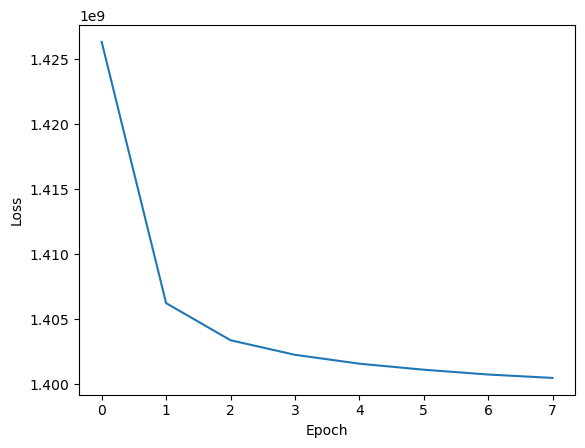

In [16]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Веса, полученные в ходе выполнения эксперимента 1 представлены ниже

In [32]:
all_weights = vae.state_dict()

In [33]:
all_weights

OrderedDict([('l1.weight',
              tensor([[[[-1.1186e-01, -9.9196e-02, -1.9032e-01, -2.3334e-02],
                        [ 1.1454e-02, -2.9477e-02, -1.0382e-01, -6.8592e-03],
                        [-2.2923e-02,  7.0349e-02,  8.2072e-02, -9.3735e-02],
                        [-2.3160e-01,  1.2411e-01, -1.1612e-01,  1.9932e-02]],
              
                       [[-1.0668e-01,  5.2638e-02,  2.4170e-02, -6.7678e-02],
                        [ 3.2534e-02,  2.4792e-02, -1.9543e-01, -1.0206e-01],
                        [ 2.3237e-02, -4.7672e-02, -1.1711e-01,  1.5694e-02],
                        [ 3.4587e-02, -1.9005e-02, -4.8300e-02,  1.5104e-01]],
              
                       [[ 6.6532e-02, -8.1913e-02,  3.7372e-02, -1.2536e-01],
                        [ 5.2955e-02, -2.0645e-02, -1.9687e-01,  9.2288e-02],
                        [-1.2680e-01, -1.3663e-01, -2.5872e-02,  7.8046e-02],
                        [-1.3350e-01,  6.6844e-02, -3.2580e-02,  5.2546e-02]]],
   

Примеры сгенерированных лиц, применяя архитектуру нейронной сети с эксперимента 1

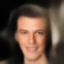

In [34]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample1.png")

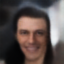

In [36]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample20.png")

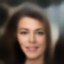

In [37]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample55.png")

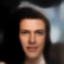

In [38]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample66.png")

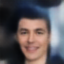

In [40]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample99.png")

Проведем эксперимент 2. Заменим функцию активации relu на leaky_relu и добавим после каждой свертки слои нормализации batch_norm, а также увеличим количество эпох до 10

In [43]:
class VAE2(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE2, self).__init__()
        
        self.latent_size = latent_size
        
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l1b = nn.BatchNorm2d(32)
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l2b = nn.BatchNorm2d(64)
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l3b = nn.BatchNorm2d(128)
        self.l4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.l4b = nn.BatchNorm2d(256)
        
        self.l41 = nn.Linear(256*4*4, self.latent_size)
        self.l42 = nn.Linear(256*4*4, self.latent_size)
        
        self.f = nn.Linear(self.latent_size, 256*4*4)
        
        self.l5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l7 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l8 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)
        
    def encoder(self, x_in):
        h = F.leaky_relu(self.l1b(self.l1(x_in)))
        h = F.leaky_relu(self.l2b(self.l2(h)))
        h = F.leaky_relu(self.l3b(self.l3(h)))
        h = F.leaky_relu(self.l4b(self.l4(h)))
        
        h = h.view(h.size(0), -1)
        
        return self.l41(h), self.l42(h)
    
    def decoder(self, z):
        z = self.f(z)
        z = z.view(-1, 256, 4, 4)
        
        z = F.leaky_relu(self.l5(z))
        z = F.leaky_relu(self.l6(z))
        z = F.leaky_relu(self.l7(z))
        z = torch.sigmoid(self.l8(z))
        
        return z
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return torch.add(eps.mul(std), mu)
    
    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [44]:
vae2 = VAE2()
    
vae2.to(device)

VAE2(
  (l1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l3b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l4b): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l41): Linear(in_features=4096, out_features=100, bias=True)
  (l42): Linear(in_features=4096, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=4096, bias=True)
  (l5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2)

In [45]:
def train(epoch):
    vae2.train()

    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        r_batch, mu, log_var = vae(data)

        loss = loss_function(r_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, train_loss / len(dataloader.dataset)))
    print("-------------------------------------------------")
    return train_loss

In [61]:
n_epoches = 10

loss_hist_2 = []

for epoch in range(1, n_epoches+1):
    loss_epoch = train(epoch)
    loss_hist_2.append(loss_epoch)

Epoch: 1 Train mean loss: 6286.76276782
-------------------------------------------------
Epoch: 2 Train mean loss: 6286.44887584
-------------------------------------------------
Epoch: 3 Train mean loss: 6286.28980053
-------------------------------------------------
Epoch: 4 Train mean loss: 6286.04918673
-------------------------------------------------
Epoch: 5 Train mean loss: 6285.90365204
-------------------------------------------------
Epoch: 6 Train mean loss: 6285.71295785
-------------------------------------------------
Epoch: 7 Train mean loss: 6285.59403326
-------------------------------------------------
Epoch: 8 Train mean loss: 6285.35603920
-------------------------------------------------
Epoch: 9 Train mean loss: 6285.24909999
-------------------------------------------------
Epoch: 10 Train mean loss: 6285.13740003
-------------------------------------------------


In [62]:
with torch.no_grad():
    counter = 0
    for i in range(100): 
        counter += 1
        z = (torch.rand(100)*2).to(device)
        sample = vae.decoder(z).to(device)
        save_image(sample.view(3, 64, 64), './sample200' + str(counter) + '.png')

Выполнив эксперимент 2 видим, что мы добились уменьшения лосса, путем замены функции активации и добавлением слоев bath_norm, результат можно видеть на графике

In [63]:
loss_hist

[1400284712.9257812,
 1400115463.6923828,
 1399955824.03125,
 1399834738.3144531,
 1399727739.9238281,
 1399639661.0664062,
 1399535454.6191406,
 1399468676.9550781,
 1399413654.8085938,
 1399348591.350586]

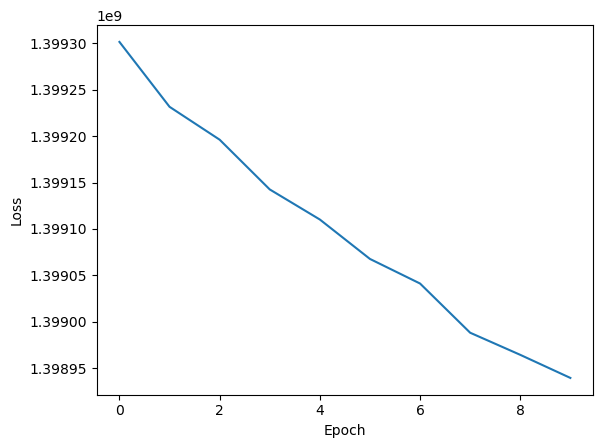

In [64]:
plt.plot(loss_hist_2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Веса, полученные при выполнении эксперимента 2 представлены ниже

In [65]:
all_weights_2 = vae2.state_dict()

In [66]:
all_weights_2

OrderedDict([('l1.weight',
              tensor([[[[ 0.1231, -0.0337,  0.0656,  0.0725],
                        [-0.0297,  0.0771, -0.0598,  0.0675],
                        [-0.0761, -0.0442, -0.1290, -0.0819],
                        [ 0.0500,  0.0370,  0.0102,  0.1202]],
              
                       [[-0.0812, -0.0912,  0.1217,  0.0044],
                        [ 0.0413, -0.1066,  0.0039,  0.0013],
                        [ 0.0682,  0.0362,  0.1408,  0.1106],
                        [ 0.0481,  0.1288,  0.0252, -0.1087]],
              
                       [[ 0.0428,  0.0606, -0.1172, -0.0049],
                        [ 0.1253,  0.0282, -0.1154, -0.0138],
                        [ 0.1043,  0.0280, -0.0625, -0.0964],
                        [ 0.0777,  0.1117,  0.0900,  0.0805]]],
              
              
                      [[[ 0.0024,  0.0214, -0.0232, -0.1326],
                        [ 0.1114, -0.0574,  0.0699, -0.0526],
                        [ 0.0512,  0.0602

Примеры сгенерированных лиц, применяя архитектуру нейронной сети с эксперимента 2

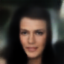

In [67]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample2001.png")

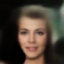

In [68]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample20020.png")

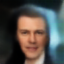

In [69]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample20055.png")

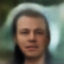

In [70]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample20099.png")

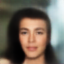

In [71]:
 Image.open(r"C:\Users\asham\Downloads\Telegram Desktop\sample20066.png")

Вывод: Выполнив лабораторную работу 1 мы познакомились с вариационным автоэнкодером и провели 2 эксперимента, с разной архитектурой нейронной сети и разными функциями активации. Наилучшей оказалась архитектура с 4 слоями свертки, между которых находятся слои batch_norm и 3 линейных слоя, функция активации leaky_relu.